# 4.5.1 Unsupervised learning capstone

In [1]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
from collections import Counter
import re
import spacy

%matplotlib inline
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn import tree,model_selection
import gensim
from gensim import corpora, models, similarities
import pyLDAvis.gensim as gensimvis
import pyLDAvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Twitter Data Analysis

In [2]:
#Using twitter api to load the data from the tweets
import tweepy
consumer_key = '66n3K6o0GfkbLO4QEoqRCA2pZ'
consumer_secret = 'T1fsUWei3jSvOehl9TmRqIuIhTGi0UEudOAeT04PMLcgodQzhS'
access_token = '86377594-cpO17ciBmTRbHzKD0AikvyIgJg7Ohfj5klfTogjVh'
access_token_secret = 'pMIxRtyha7XNeyBITlLwprYGwfl2DM4laCB2dUaDXCrCA'
 
def  twitter_Access():
     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
     auth.set_access_token(access_token, access_token_secret)
     api = tweepy.API(auth, wait_on_rate_limit=True)
     return api
extract = twitter_Access()

We will first load the tweets  from twitter for  some famous politicians- Donald Trump,Hillary Clinton,Barnie Sanders and Barack Obama.Then we can deep dive on the analysis to check aspects such as most liked tweet,most recent tweet and so on.

In [3]:
Dtweets = extract.user_timeline(screen_name="realDonaldTrump", count=200, tweet_mode='extended')
Otweets = extract.user_timeline(screen_name="BarackObama", count=200, tweet_mode='extended')
Htweets =extract.user_timeline(screen_name="HillaryClinton", count=200, tweet_mode='extended')
Mtweets =extract.user_timeline(screen_name="MikeBloomberg", count=200, tweet_mode='extended')
Stweets =extract.user_timeline(screen_name="SenSanders", count=200, tweet_mode='extended')

In [4]:
# Creating Data frame and all the relevant columns for detailed analysis
Donald = pd.DataFrame(data=[tweet.full_text for tweet in Dtweets], columns=['Tweets']) 
Donald['Tweet Length']  = np.array([len(tweet.full_text) for tweet in Dtweets])
Donald['ID']   = np.array([tweet.id for tweet in Dtweets])
Donald['Date Posted'] = np.array([tweet.created_at for tweet in Dtweets])
Donald['OS'] = np.array([tweet.source for tweet in Dtweets])
Donald['Likes']  = np.array([tweet.favorite_count for tweet in Dtweets])
Donald['Retweets']   = np.array([tweet.retweet_count for tweet in Dtweets])
Donald['Weekday']  = Donald['Date Posted'].dt.weekday_name
Donald['wt'] =Donald['Date Posted'].dt.weekday
Donald['Month'] =Donald['Date Posted'].dt.month

Obama = pd.DataFrame(data=[tweet.full_text for tweet in Otweets], columns=['Tweets']) 
Obama['Tweet Length']  = np.array([len(tweet.full_text) for tweet in Otweets])
Obama['ID']   = np.array([tweet.id for tweet in Otweets])
Obama['Date Posted'] = np.array([tweet.created_at for tweet in Otweets])
Obama['OS'] = np.array([tweet.source for tweet in Otweets])
Obama['Likes']  = np.array([tweet.favorite_count for tweet in Otweets])
Obama['Retweets']   = np.array([tweet.retweet_count for tweet in Otweets])
Obama['Weekday']  = Obama['Date Posted'].dt.weekday_name
Obama['wt'] =Obama['Date Posted'].dt.weekday
Obama['Month'] =Obama['Date Posted'].dt.month

Now, just checking if any column is null or not.It seems like there are no null values

In [8]:
Donald.isnull().sum()

Tweets          0
Tweet Length    0
ID              0
Date Posted     0
OS              0
Likes           0
Retweets        0
Weekday         0
wt              0
Month           0
dtype: int64

In [9]:
Obama.isnull().sum()

Tweets          0
Tweet Length    0
ID              0
Date Posted     0
OS              0
Likes           0
Retweets        0
Weekday         0
wt              0
Month           0
dtype: int64

Lets use describe, it will show us all the details about columns which might help for analysis

In [10]:
Donald.describe()

,Tweet Length,ID,Likes,Retweets,wt,Month
count,1.0,1.000000e+00,1.0,1.0,1.0,1.0
mean,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0
25%,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0
50%,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0
75%,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0
max,271.0,1.102583e+18,18222.0,4184.0,0.0,3.0


In [11]:
Obama.describe()

,Tweet Length,ID,Likes,Retweets,wt,Month
count,200.000000,2.000000e+02,2.000000e+02,2.000000e+02,200.000000,200.000000
mean,182.040000,9.617774e+17,3.984397e+05,8.642868e+04,2.555000,7.810000
std,68.549937,1.000419e+17,5.401294e+05,1.524500e+05,1.937977,3.771608
min,47.000000,7.917658e+17,0.000000e+00,5.840000e+02,0.000000,1.000000
25%,132.750000,8.943516e+17,5.613675e+04,1.264925e+04,1.000000,4.000000
50%,158.500000,9.709712e+17,2.279175e+05,3.897850e+04,2.000000,9.000000
75%,254.500000,1.059517e+18,4.933168e+05,9.963525e+04,4.000000,11.000000
max,306.000000,1.098659e+18,4.490314e+06,1.655103e+06,6.000000,12.000000


Lets check if Donald Trump has ever mentioned any of Obama, Sanders, Hillary in any of his tweets

In [221]:
import re
Donald.Tweets[Donald.Tweets.str.contains('Obama', 'Barack', flags= re.IGNORECASE)].count()


3

In [218]:
import re
Donald.Tweets[Donald.Tweets.str.contains('Bernie', 'Sanders', flags= re.IGNORECASE)].count()

1

In [219]:
import re
Donald.Tweets[Donald.Tweets.str.contains('Hillary', 'Clinton', flags= re.IGNORECASE)].count()

5

In [ ]:
Yes, Trump has mentioned Obama 3 times, sanders 1 time,hillay 5 times in his tweets.Lets do the vice versa now

In [214]:
import re
Obama.Tweets[Obama.Tweets.str.contains('Donald', 'Trump', flags= re.IGNORECASE)].count()

0

But looks like Obama has never mentioned Trump in this tweets But Trump has mentioned Obama, Bernie Sanders and Hillary Clinton in his tweets.Now lets check Trumps latest tweet and most likes

In [215]:
#To get latest tweet date
Donald.loc[Donald['Date Posted'].idxmax()]


level_0                                                         0
index                                                           0
Tweets          THANK YOU to our generous hosts in Hanoi this ...
Tweet Length                                                  150
ID                                            1101065802067861505
Date Posted                                   2019-02-28 10:25:18
OS                                             Twitter for iPhone
Likes                                                      107107
Retweets                                                    21334
Weekday                                                  Thursday
wt                                                              3
Month                                                           2
Name: 0, dtype: object

In [216]:
#the most liked tweet
Donald.loc[Donald['Likes'].idxmax()]

level_0                         128
index                           128
Tweets           BUILDING THE WALL!
Tweet Length                     18
ID              1096924708132581377
Date Posted     2019-02-17 00:10:04
OS               Twitter for iPhone
Likes                        299248
Retweets                      66178
Weekday                      Sunday
wt                                6
Month                             2
Name: 128, dtype: object

Wow!It looks like the most liked tweet is building the wall.Latest tweet was today

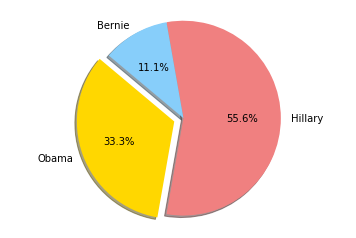

In [222]:
#creating pie chart for politicians mentioned
labels = 'Obama', 'Hillary', 'Bernie'
sizes = [3, 5, 1]
explode = (0.1, 0, 0)  # explode 1st slice
colors = ['gold', 'lightcoral', 'lightskyblue']
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

The above pie shart shows Trump has mentioned Hillary clinton in most of his tweets

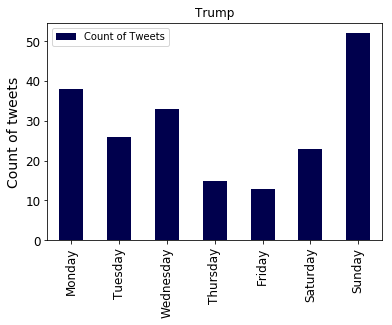

In [223]:
import matplotlib.pyplot as plt
#when using notebook make sure to add
%matplotlib inline  
Weekday_Tweets = Donald.groupby(['wt', 'Weekday']).agg({'Weekday': np.count_nonzero}).plot(colormap='seismic', fontsize=12, kind = 'bar')
Weekday_Tweets.set_ylabel('Count of tweets', fontsize=14)
Weekday_Tweets.set_xlabel('', fontsize=14)
plt.xticks(np.arange(7), ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))
plt.title('Trump')
plt.legend(['Count of Tweets']);

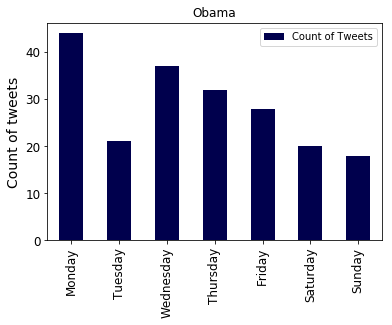

In [231]:
import matplotlib.pyplot as plt
#when using notebook make sure to add
%matplotlib inline  
Weekday_Tweets = Obama.groupby(['wt', 'Weekday']).agg({'Weekday': np.count_nonzero}).plot(colormap='seismic', fontsize=12, kind = 'bar')
Weekday_Tweets.set_ylabel('Count of tweets', fontsize=14)
Weekday_Tweets.set_xlabel('', fontsize=14)
plt.xticks(np.arange(7), ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))
plt.title('Obama')
plt.legend(['Count of Tweets']);

The above plots show that Donald Trump tweets mostly on Sundays and Obama on Mondays

([<matplotlib.axis.XTick at 0x23f0036f710>,
 <a list of 7 Text xticklabel objects>)

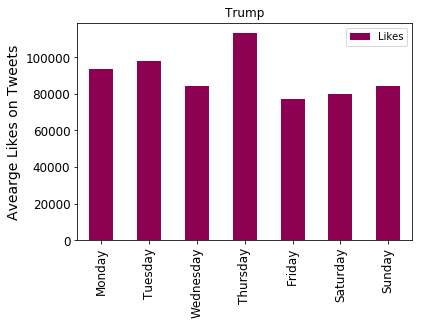

In [227]:
AvgLikes = Donald.groupby(['wt']).agg({'Likes': np.mean}).plot(colormap='PiYG', fontsize=12, kind = 'bar')
AvgLikes .set_ylabel('Avearge Likes on Tweets', fontsize=14)
AvgLikes.set_title('Trump')
AvgLikes .set_xlabel('')
plt.xticks(np.arange(7), ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

([<matplotlib.axis.XTick at 0x23f77185710>,
 <a list of 7 Text xticklabel objects>)

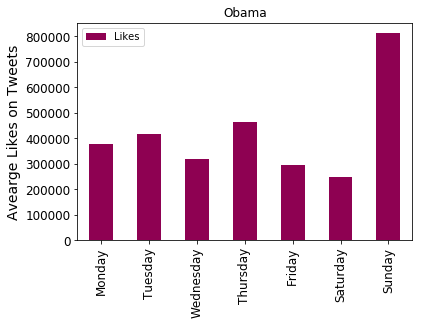

In [230]:
AvgLikes = Obama.groupby(['wt']).agg({'Likes': np.mean}).plot(colormap='PiYG', fontsize=12, kind = 'bar')
AvgLikes .set_ylabel('Avearge Likes on Tweets', fontsize=14)
AvgLikes.set_title('Obama')
AvgLikes .set_xlabel('')
plt.xticks(np.arange(7), ("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"))

From both the charts, we observe, people like Trumps tweets on Thursday and Obamas tweet on Sunday.Thats little weird.Now, we have done enough analysis of tweets. Lets do some data cleaning/preprocessing first and use supervised and unsupervised models

# Data Cleaning and Preprocessing the data

First of all, I am creating a file for each politican and saving there latest 200 tweets in a file and then retrieving them

In [5]:

#Twitter's API only allows for 200 records per call
TWEETS_PER_CALL = 200 

def save_tweets(screen_nm, tweets):
    # 'a' appends to the .json we wrote with 'w' above
    with open(f'C:\\Users\\Ankush\\Desktop\\{screen_nm}.json', 'a') as f:
        for tweet in tweets:
            json.dump([tweet.text, screen_nm], f); f.write('\n')

def get_tweets(screen_nm, desired_ct):
    
    #desired_ct is the number of tweets the user wants to include
    tweet_list = []

    #grab the current maximum tweet id for provided screen name, which will be the id of the first tweet stored in the object
    tweets = extract.user_timeline(screen_name = screen_nm,count=50)
    save_tweets(screen_nm, tweets)
    return tweet_list

In [6]:
trump = get_tweets('realDonaldTrump',50)
clinton = get_tweets('HillaryClinton', 50)
bernie = get_tweets('SenSanders', 50)
obama = get_tweets('BarackObama', 50)


In [6]:
handles = ['realDonaldTrump', 'HillaryClinton', 'SenSanders', 'BarackObama', 'MikeBloomberg']


Now, lets combine all the tweets in one list and then into a dataframe so that we can ceate two columns- tweets and the author

In [7]:

#Combine all tweets into 1 list

full_tweets = []
for handle in handles:
    with open('C:\\Users\\Ankush\\Desktop\\{}.json'.format(handle)) as f: 
        full_tweets.append([json.loads(line) for line in f])
        
#Only want the first 2100 from each author (retweets caused the full amount for each author to be < 3200, and each has at least
#2100 non RTs)
all_tweets = []
for auth in full_tweets:
    all_tweets.extend(auth[:500])
    
#Store in dataframe
tweet_df = pd.DataFrame(all_tweets, columns = ['Tweets', 'Author'])

In [17]:
tweet_df.head()

,Tweets,Author
0,....This will be remembered as one of the most...,realDonaldTrump
1,Senate Democrats just voted against legislatio...,realDonaldTrump
2,"If a deal is made with China, our great Americ...",realDonaldTrump
3,Heading over to Vietnam for my meeting with Ki...,realDonaldTrump
4,China Trade Deal (and more) in advanced stages...,realDonaldTrump


In [12]:
tweet_df.head()

,Tweets,Author
0,....This will be remembered as one of the most...,realDonaldTrump
1,Senate Democrats just voted against legislatio...,realDonaldTrump
2,"If a deal is made with China, our great Americ...",realDonaldTrump
3,Heading over to Vietnam for my meeting with Ki...,realDonaldTrump
4,China Trade Deal (and more) in advanced stages...,realDonaldTrump


Now, we are trying to remove uneven word space and trying to join the words with single space

In [8]:
tweet_full= ' '.join(tweet_df['Tweets'])

Now, we can parse the cleaned data into tokens as below

In [9]:
nlp = spacy.load('en')
tweet_full=nlp(tweet_full)

In [10]:
def bag_of_words(text):
    allwords = [token.lemma_ for token in text if not token.is_stop and not token.is_punct and not token.like_url and 
                not token.like_num and not token.is_space and token.is_ascii and len(token.lemma_) > 1]
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]

In [11]:
bow = bag_of_words(tweet_full)

#Let's clean this up a bit 
replace_words = [r'/n', r'\\n', r'\n', r'--', r'-', 'https:\/\/t\.co\/[\w\d]+', r'amp', r'&', r'w/', "'s"]
bow = [re.sub('|'.join(replace_words), '', word) for word in bow]

In [12]:
#Create dataframe with counts of our bag of words as features 
def bow_features(sentences, bow):
    
    partsofspeechlist = []
    orth_list = []
    dep_list=[]
    
    for sent in sentences[0]:
        for token in sent:
                partsofspeechlist.append(token.pos_)

    parts = (set(partsofspeechlist))
    for orth in sentences[0]:
        for token in orth:
                orth_list.append(token.orth_)

    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns = set(list(bow)+ list(parts)))
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, bow] = 0
    #df['tweet_length'] = 0
    #df['tweet_punct_count'] = 0 
    #df['upper_case'] = 0 
    df.loc[:, parts] = 0
    
    for i, sent in enumerate(sentences[0]):

        tweet_len = 0    
        num_punct = 0
        
        # Populate the row with word counts (only include the ones from our bag of words)
        words = [token.lemma_ for token in sent
                 if token.lemma_ in bow]
        
        #"words" collects all bow matches from each sentence
        for word in words:
            df.loc[i, word] += 1
        
        #Add part of speech counter and tweet length
        for token in sent:
            df.loc[i, token.pos_] += 1
            if not token.is_punct:
                tweet_len += 1
            else:
                num_punct += 1
            
        #Create a feature for all CAPS words  
           # if ((str(token).isupper()) & (len(str(token)) > 1)):
             #   df.loc[i, 'upper_case'] += 1


        #df.loc[i, 'tweet_length'] = tweet_len
        #df.loc[i, 'tweet_punct_count'] = num_punct

        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

    return df

In [13]:
#Tokenize our tweets using spaCy (for more interesting features later on)
all_tweets_nlp = []
all_tweets_nlp.append([nlp(tweet[0]) for tweet in all_tweets])
all_tweets_nlp.append([nlp(tweet[1]) for tweet in all_tweets])

In [14]:
df = bow_features(all_tweets_nlp, bow)
df.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000


,,safe,@meetthepress,senate,heart,speech,call,proud,university,volunteer,...,team,venezuelan,intelligence,outline,with,hoax,christmas,bush,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(...., This, will, be, remembered, as, one, of...",(realDonaldTrump)
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Senate, Democrats, just, voted, against, legi...",(realDonaldTrump)
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"(If, a, deal, is, made, with, China, ,, our, g...",(realDonaldTrump)
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,"(Heading, over, to, Vietnam, for, my, meeting,...",(realDonaldTrump)
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(China, Trade, Deal, (, and, more, ), in, adva...",(realDonaldTrump)


# Supervised Learning

We can now use all the supervised learning models for classification since we have input variables and labels both

# Random Forest

In [50]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
X = np.array(df.drop(['text_sentence', 'text_source'],1))

#y needs to be str or int, cannot be spacy doc, so convert here
Y = df['text_source'].apply(lambda x: str(x))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_train)



print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9966666666666667

Test set score: 0.884


Wow, looks like there is overfitting in training and test data both.This might have been because of high number of features.It is suspectable to random noise which we can oberserve by looking at overfitting.Random forest/Decision tree doesnot perform well with huge number of features as above.Using Gridsearch cv will not really help here either.So, we should ignore this model

In [19]:
lr = LogisticRegression(C=1e9)
lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 1.0

Test set score: 0.918


Same has happend for Logisic Regression,lot of overfitting.

In [20]:
#KNN
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_train)
print('Training set score:', knn_model.score(X_train, y_train))
print('\nTest set score:', knn_model.score(X_test, y_test))

Training set score: 0.9246666666666666

Test set score: 0.693


KNN has peformed better then random forest and Logistic Regression.The reason being  that it is robust to random noise which we can observe looking at the dataset.Also, this model performs better for large dataset which is applicable to this dataset.We need to play around with number of neighbours to get the best accuracy.In this case, if we increase the neighbours, accuracy will decrease.The reason being the huge amount of data in the dataset which is affecting the accuracy.Here Gridsearchcv might have helped but its takes too much time to get the best parameters so I ignored it for now.

# Cross Validation Score

In [21]:
from sklearn.model_selection import cross_val_score
print("Training data accuracy : ",cross_val_score(knn_model, X_train, y_train, cv=10))
print("Testing data accuracy : ",cross_val_score(knn_model, X_test, y_test, cv=10))

Training data accuracy :  [0.61437908 0.64900662 0.67333333 0.63333333 0.57333333 0.56666667
 0.59333333 0.62416107 0.63758389 0.59459459]
Testing data accuracy :  [0.64705882 0.4950495  0.55445545 0.41       0.54       0.49
 0.47       0.59       0.54545455 0.5257732 ]


# Confusion Matrix

In [22]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(confusion_matrix(y_train, y_pred_knn))
print('Accuracy Score:',accuracy_score(y_train, y_pred_knn))

[[299   0   0   0   0]
 [ 13 279   0   0   0]
 [ 15  16 260   0   0]
 [  9  15  11 276   0]
 [  9  11   5   9 273]]
Accuracy Score: 0.9246666666666666


# Classification Report

In [23]:
#Classification Report
from sklearn.metrics import classification_report
print("Classification Report :",classification_report(y_train, y_pred_knn))

Classification Report :                  precision    recall  f1-score   support

    BarackObama       0.87      1.00      0.93       299
 HillaryClinton       0.87      0.96      0.91       292
  MikeBloomberg       0.94      0.89      0.92       291
     SenSanders       0.97      0.89      0.93       311
realDonaldTrump       1.00      0.89      0.94       307

      micro avg       0.92      0.92      0.92      1500
      macro avg       0.93      0.93      0.92      1500
   weighted avg       0.93      0.92      0.92      1500



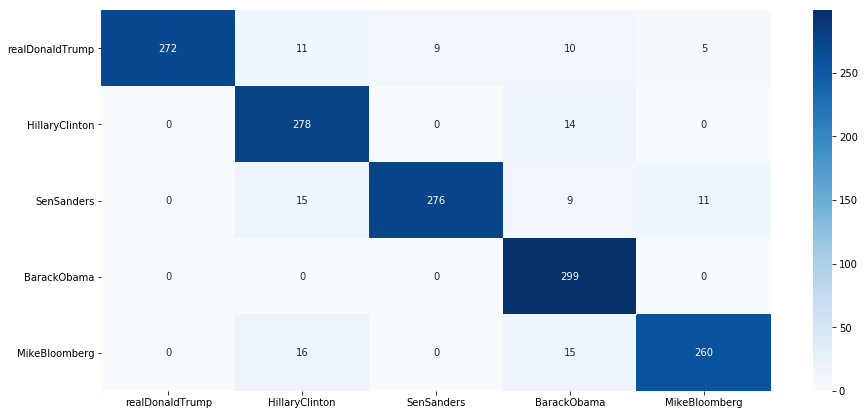

In [47]:
conf = confusion_matrix(y_train, y_pred_knn, labels = handles)

df_cm = pd.DataFrame(conf, index = [i for i in handles],
                  columns = [i for i in handles])
plt.figure(figsize = (15,7))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt = 'd')

The accuracies for cross validation,confusion matrix, classification report look good.These are good numbers keeping in mind, all the labels have good accuracy.Labels for barack obama and donald trump have little overfitting but overall its performed well.The overfitting is very less if we see the confusion matrix above for the labels.Thats make it a good model to apply.Also, we were not able to AUC since its appliaction is limited to  binary labels

Now, lets use unsupervised learning since we have learned a fair amount of that.Lets apply that to this dataset and see how it behaves to this dataset

# Unsupervised Learning

Lets do k means cluster and check how it peformed with the dataset.First we will take value using tfidfvectoizer and convert into tokens and classify the data per cluster

### Tf-idf Model

In [74]:

#Try TF-IDF to see if we can increase prediction accuracy. Also experiment by increasing the minimum document frequency 
#to reduce the feature space...

X_train, X_test, y_train, y_test = train_test_split(tweet_df['Tweets'], tweet_df['Author'], test_size = 0.25, random_state = 42)

vector = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=2, # only use words that appear at least 2x
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

X_train_tfidf = vector.fit_transform(X_train)
X_test_tfidf = vector.transform(X_test)

fit = rfc.fit(X_train_tfidf, y_train)
y_pred = rfc.predict(X_test_tfidf)
print (X_train_tfidf.shape)
print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

(1875, 3610)
Training set score: 0.9978666666666667

Test set score: 0.9552


# K means clustering

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

Homogeneity: 0.033
Completeness: 0.040
V-measure: 0.036
Adjusted Rand-Index: 0.017
Silhouette Coefficient: 0.005


ValueError: 'c' argument has 2500 elements, which is not acceptable for use with 'x' with size 1, 'y' with size 1.

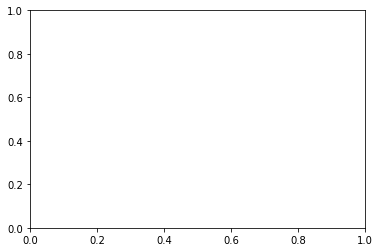

In [98]:
#Let's keep our data in high dimensional form first, to see what (if any) insights we can gain from clustering.

#Try K-Means MiniBatch (K-Means is very resource intensive for high dimnesional data) and assume 10 clusters to begin with

#Create normalized version of full dataset (we don't need to reserve any for training, we just want to cluster for now)

#Normalize the data to the unit vector. Should we normalize by row or column? Normalize by row - gives a better representation of tweet composition. Likely more meaningful than the relative freq magnitude
#of each word relative to that word's frequencies in all tweets

X = tweet_df['Tweets']
X_norm_tfidf = normalize(vector.fit_transform(X))

true_k = 5
labels_class = Y
km = KMeans(n_clusters=5,init='k-means++',random_state=42)
y_pred=KMeans(n_clusters=5, random_state=42).fit_predict(X_norm_tfidf)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_norm_tfidf)
labels = km.labels_
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_class, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels_class, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_class, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels_class, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, km.labels_, sample_size=5000))
plt.scatter(X_norm_tfidf[:, 0], X_norm_tfidf[:, 1], c=y_pred)
plt.show()

<2500x4555 sparse matrix of type '<class 'numpy.float64'>'
	with 26953 stored elements in Compressed Sparse Row format>

Overall results are poor.It looks like there is no clear classification for all the labels and most of labels are overlapping,which is not a good sign.Lets use min batch k-means.Usually it improves clustering,

# Mini Batch KMeans

In [20]:
labels = Y
kmini = MiniBatchKMeans(n_clusters=5, init='k-means++', batch_size=2000)

print("Clustering sparse data with %s" % km)
t0 = time()
kmini.fit(X_norm_tfidf)
mini_labels = kmini.labels_
print("Done in %0.3fs" % (time() - t0))
print()
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, kmini.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, kmini.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, kmini.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, kmini.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_norm_tfidf, kmini.labels_, sample_size=1000))

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
Done in 0.250s

Homogeneity: 0.032
Completeness: 0.042
V-measure: 0.037
Adjusted Rand-Index: 0.014
Silhouette Coefficient: 0.005


In [30]:
tweet_df['MiniBatchLabels'] = mini_labels
for label in set(mini_labels):
    print('Cluster: %d' % label)
    print(tweet_df[tweet_df.MiniBatchLabels == label].groupby('Author').count())

    

Cluster: 0
                 Tweets  MiniBatchLabels
Author                                  
BarackObama         364              364
HillaryClinton      320              320
MikeBloomberg       330              330
SenSanders          274              274
realDonaldTrump     313              313
Cluster: 1
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          45               45
HillaryClinton       71               71
MikeBloomberg        91               91
SenSanders           37               37
realDonaldTrump      94               94
Cluster: 2
                 Tweets  MiniBatchLabels
Author                                  
BarackObama          15               15
HillaryClinton       32               32
MikeBloomberg        29               29
SenSanders           31               31
realDonaldTrump      35               35
Cluster: 3
                 Tweets  MiniBatchLabels
Author                                  
BarackObama  

We have to play around with  the values of number of clusters, clusters between 10 and 15 seems to produce better results than less clusters.Lets get into more details and try to check the tweets for some of the clusters

In [31]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 0]).head(10)

,Tweets,Author,MiniBatchLabels
323,California has been forced to cancel the massi...,realDonaldTrump,0
2253,Good conversation with Mayor @Kriseman today o...,MikeBloomberg,0
777,"Thank you, Mary Oliver, for giving so many of ...",HillaryClinton,0
1856,"Through faith, love, and resolve the character...",BarackObama,0
2494,Thank you to every member of @MomsDemand in Io...,MikeBloomberg,0
1525,Enjoy the holiday season with the ones you lov...,BarackObama,0
2180,Great to see Pittsburgh Mayor @BillPeduto toda...,MikeBloomberg,0
1706,"In the year since their friends were killed, t...",BarackObama,0
320,Reviewing the funding bill with my team at the...,realDonaldTrump,0
1141,"In the year 2019, no one in America, especiall...",SenSanders,0


In [32]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 2]).head(10)

,Tweets,Author,MiniBatchLabels
1205,This drug was free for patients just weeks ago...,SenSanders,2
288,....There is a lot of explaining to do to the ...,realDonaldTrump,2
2277,RT @ParisPittsburgh: As Mayors across the U.S....,MikeBloomberg,2
850,"In less than a week, there will be a run-off i...",HillaryClinton,2
85,"Hope you are enjoying your President’s Day, ou...",realDonaldTrump,2
1215,The current fight in DC is about more than a w...,SenSanders,2
1377,9 years ago the disastrous Citizens United dec...,SenSanders,2
2060,One week sums up a failing presidency. https:/...,MikeBloomberg,2
643,Bill and I will be traveling to Washington to ...,HillaryClinton,2
2033,A new poll shows that the vast majority of Ame...,MikeBloomberg,2


In [36]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 3]).head(10)

,Tweets,Author,MiniBatchLabels
1462,"Trump's top intelligence officials, European a...",SenSanders,3
434,RT @GOPChairwoman: Drug trafficking at our sou...,realDonaldTrump,3
1390,"President Trump said that ""nobody has been bet...",SenSanders,3
2407,Unilaterally declaring a national emergency to...,MikeBloomberg,3
1483,Will Trump talk about climate change in his St...,SenSanders,3
1469,"Trump talks a lot about ""freedom."" But people ...",SenSanders,3
1188,"Since Trump was elected, the five richest peop...",SenSanders,3
1178,We have a president who is a racist.\n\nToday ...,SenSanders,3
1044,Trump gave the top 1% and large corporations $...,SenSanders,3
1057,"Trump's demonization of Latinos is racist, it’...",SenSanders,3


In [37]:
shuffle(tweet_df[tweet_df.MiniBatchLabels == 4]).head(10)

,Tweets,Author,MiniBatchLabels
290,“After two years and interviewing more than tw...,realDonaldTrump,4
6,...Danny’s recovery reflects the best of what ...,realDonaldTrump,4
1905,Happy Valentine’s Day to the extraordinarily s...,BarackObama,4
609,"In two years, @RunforSomething has recruited 2...",HillaryClinton,4
90,“After two years and interviewing more than tw...,realDonaldTrump,4
513,"Based on my work, this is a good example for u...",HillaryClinton,4
2248,RT @JohnFeinblatt: Quick summary of my @Newswe...,MikeBloomberg,4
1541,"Of course, @MichelleObama’s my wife, so I’m a ...",BarackObama,4
1741,"Of course, @MichelleObama’s my wife, so I’m a ...",BarackObama,4
1224,Amazon made $16.8 billion in profits over the ...,SenSanders,4


The above shows some of the tweets with their clusters.We did this to get some idea of clusters with their tweets and the author for the tweets

In [65]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_norm_tfidf.toarray(), quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm_tfidf.toarray())

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 1


The mean-shift estimated only 1 clusters which doesn't look good, since we have 5 authors, so ideally there should have been 5 clusters.This makes sense because Mean shift makes no assumptions about the nature of the data or the number of clusters

# BoW Feature with Supervised learning


In [67]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [68]:
train_data_bow = count_vect.fit_transform(X_train)

In [69]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Random Forest Classifier
rfc_bow1 = ensemble.RandomForestClassifier(random_state=42)
rfc_bow1.fit(train_data_bow,y_train)
cv_bow1 = cross_val_score(rfc_bow1, train_data_bow, y_train, cv=5)


#Test
y_true, y_pred = y_train, rfc_bow1.predict(train_data_bow)
print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(cv_bow1))
print("mean = {:.3}".format(cv_bow1.mean()))
print(pd.crosstab(y_true, y_pred))

C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test Set score = 0.998 
Training set Cross validation = [0.84350133 0.856      0.88266667 0.9171123  0.86898396]
mean = 0.874
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              359               0              0           0   
HillaryClinton             0             389              0           0   
MikeBloomberg              0               0            381           0   
SenSanders                 0               0              0         373   
realDonaldTrump            0               0              0           0   

col_0            realDonaldTrump  
Author                            
BarackObama                    2  
HillaryClinton                 1  
MikeBloomberg                  0  
SenSanders                     0  
realDonaldTrump              370  


Overfitting again.The model doesnt look accuarate enough.Lets check SVC

In [70]:

from sklearn.metrics import confusion_matrix


knn_model_bow = KNeighborsClassifier(n_neighbors=2)
knn_model_bow.fit(train_data_bow,y_train)
knn_model_cv = cross_val_score(knn_model_bow, train_data_bow, y_train, cv=10)


print("Report:")
y_true, y_pred = y_train, knn_model_bow.predict(train_data_bow)
#print(classification_report(y_true, y_pred))

print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(knn_model_cv))
print("mean = {:.3}".format(knn_model_cv.mean()))
pd.crosstab(y_true, y_pred)

Report:
Test Set score = 0.995 
Training set Cross validation = [0.76315789 0.83510638 0.79787234 0.81818182 0.78609626 0.80748663
 0.81818182 0.81283422 0.86096257 0.80748663]
mean = 0.811


col_0,BarackObama,HillaryClinton,MikeBloomberg,SenSanders,realDonaldTrump
Author,,,,,
BarackObama,361,0,0,0,0
HillaryClinton,0,390,0,0,0
MikeBloomberg,1,2,378,0,0
SenSanders,1,2,2,368,0
realDonaldTrump,1,1,0,0,368


The above looks to be better than any other models.There looks to be some overfitting but cross validation is better than other models.Mean value is better as well.Over all ,I am happy with this since it is performing better 

# Latent Semantic Analysis with Unsupervised Learning


Let's use Latent Semantic Analysis to reduce the tf-idf into a lower dimensional space. This is similar to Principal Component Analysis (PCA), where we reduce the number of rows and combine them into new dimensions.

In [75]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

tweets_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(tweets_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 92.27307314740221
Component 0:
Tweets
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319656
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319656
RT @IndivisibleTeam: Trump just declared a #FAKENationalEmergency at the border. Trump is going around Congress, the will of the people, &amp;…    0.319656
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9jKdjyqt    0.289355
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9jKdjyqt    0.289355
The Bloomberg American Cities Climate Challenge supports new ideas for fighting climate change &amp; strong mayors who… https://t.co/eG9j

Name: 5, dtype: float64
Component 6:
Tweets
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392728
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392728
This National Gun Violence Awareness Day, show your commitment to keeping our kids safe from gun violence. Then, fo… https://t.co/Nr5qxK8sgu        0.392728
On this National Gun Violence Awareness Day, let your voice be heard and show your commitment to reducing gun viole… https://t.co/S7dth6Ywb0        0.333225
On this National Gun Violence Awareness Day, let your voice be heard and show your commitment to reducing gun viole… https://t.co/S7dth6Ywb0        0.333225
I’ve been involved in the gun safety movement for many years &amp; I’m glad to say I've never seen more energy behind t… https://t.co/hJyPHHmonM    0.294543
I’ve been invo

# LSA Component Examination


## Component 0


Hillary Clinton is giving her views about Donald Trumps performance as a president and providing some facts

## Component 1


Mike Bloomberg is supporting new initiative for critical subjects such as Climate Change

## Component 2

Barnie Sanders showing his views about Trumps Presidency

## Component 3

Barnie Sanders showing his views about Climate Change

## Component 4

Obama speaks about Obama care and about people should vote

## Component 5

Mike Bloomberg speaking about gun voilence and other general topics

## Component 6

Hillary Clinton speaking about gun voilence and other general topics

## Component 7

Donald Trump speaking about general white house work

## Component 8

Barack Obama celebrating Valetine day with his wife Michelle Obama

## Component 9



Donald Trump speaking about general white house work

If we notice, all the clusters do not have any pattern.So, I think clusters are not able to identify any patterns which is not good

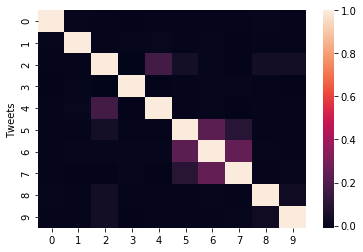

Key:
0 ....This will be remembered as one of the most shocking votes in the history of Congress. If there is one thing we… https://t.co/iu6xoJ8xmL
1 Senate Democrats just voted against legislation to prevent the killing of newborn infant children. The Democrat pos… https://t.co/MGj4b6eXtM
2 If a deal is made with China, our great American Farmers will be treated better than they have ever been treated before!
3 Heading over to Vietnam for my meeting with Kim Jong Un. Looking forward to a very productive Summit!
4 China Trade Deal (and more) in advanced stages. Relationship between our two Countries is very strong. I have there… https://t.co/InPk1QI5dW
5 ...our foreign partners. Recovering American hostages is a priority of my Admin, and with Danny’s release, we have… https://t.co/awuDu1fG9i
6 ...Danny’s recovery reflects the best of what the United States &amp; its partners can accomplish.
We work every day to… https://t.co/Gghg9zS0Sv
7 It is my honor today to announce that Danny Burch

In [41]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


Above heatmap shows the sentences doesnt look to be similar at all.It is able to correctly differentiate sentences.Now,Lets try to find clusters near Centroid and check if it is giving a specific pattern

# Clusters Within Centroid using K-means

In [97]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vector.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
        print
plt.scatter(terms[:,0], terms[:,1], 
            marker='x', s=200, linewidths=3, c=y_pred)

Top terms per cluster:
Cluster 0:
 trump
 today
 great
 just
 time
 health
 president
 new
 years
 americans
Cluster 1:
 country
 world
 history
 people
 richest
 pay
 obamafoundation
 rt
 leaders
 believe
Cluster 2:
 rt
 climate
 thank
 change
 realdonaldtrump
 cities
 fight
 parispittsburgh
 bloomberg
 amp
Cluster 3:
 day
 make
 good
 sure
 michelleobama
 vote
 happy
 country
 power
 today
Cluster 4:
 people
 states
 support
 united
 young
 elections
 venezuela
 american
 trump
 president


TypeError: list indices must be integers or slices, not tuple

If we observe above, the words within the clusters are random.There is no specific pattern within the clusters.This shows that words near the centriod do not follow any pattern.All the clusters above have no similarities with in the clusters

###   K-Means Clustering with LSA 

In [76]:

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# Normalize the data.
X_norm = normalize(X_train_lsa)

# Calculate predicted values.
y_pred = KMeans(n_clusters=25, random_state=42).fit_predict(X_norm)

# Check the solution against the data.
print('Comparing k-means clusters against politicians:')
pd.crosstab(y_train, y_pred)

Comparing k-means clusters against politicians:


col_0,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Author,,,,,,,,,,,,,,,,,,,,,
BarackObama,3,61,17,10,2,0,11,3,38,16,...,0,12,27,9,12,19,5,17,0,5
HillaryClinton,5,13,36,14,13,0,24,16,22,14,...,0,10,16,19,12,16,6,25,13,13
MikeBloomberg,3,6,30,15,29,2,2,11,9,7,...,4,4,9,11,7,41,3,28,43,4
SenSanders,17,8,6,39,9,59,14,11,16,19,...,0,14,1,5,5,20,0,23,15,4
realDonaldTrump,15,4,9,6,7,6,5,20,15,3,...,21,19,6,27,7,15,0,48,0,19


# LSA with Supervised Approach

Lets try LSA to check the accuracy using Random Forest.This is a superivsed approach to check how LSA  impacted the accuracy

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

rfc_lsa1 = ensemble.RandomForestClassifier(random_state=42)
rfc_lsa1.fit(X_train_lsa,y_train)
cv_lsa1 = cross_val_score(rfc_lsa1, X_train_lsa, y_train, cv=5)


#Test
y_true, y_pred = y_train, rfc_lsa1.predict(X_train_lsa)
print("Test Set score = {:.3} ".format(accuracy_score(y_true, y_pred)))


print("Training set Cross validation = {}".format(cv_lsa1))
print("mean = {:.3}".format(cv_lsa1.mean()))
print(pd.crosstab(y_true, y_pred))



C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test Set score = 1.0 
Training set Cross validation = [0.80106101 0.8        0.80266667 0.82352941 0.82352941]
mean = 0.81
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              361               0              0           0   
HillaryClinton             0             390              0           0   
MikeBloomberg              0               0            381           0   
SenSanders                 0               0              0         373   
realDonaldTrump            0               0              0           0   

col_0            realDonaldTrump  
Author                            
BarackObama                    0  
HillaryClinton                 0  
MikeBloomberg                  0  
SenSanders                     0  
realDonaldTrump              370  


Oh no!these new features did not help at all .We can see overfitting.Like try logistic Regression

In [98]:
logit = LogisticRegression()
fit = logit.fit(X_train_lsa_df, y_train)
y_pred = logit.predict(X_train_lsa_df)
print ('Training set score:', rfc.score(X_train_lsa_df, y_train))


C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ankush\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.9994666666666666


In [100]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train_lsa_df, y_train)
y_pred_knn = clf.predict(X_train_lsa_df)
print('Training set score:', clf.score(X_train_lsa_df, y_train))


Training set score: 0.9994666666666666


In [103]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc_model = svc.fit(X_train_lsa,y_train)
print(svc_model)
print('Training set score:', svc_model.score(X_train_lsa,y_train))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training set score: 0.9861333333333333


In [105]:
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
svm_t200 = SVC(kernel='linear')
svm_t200.fit(X_train_lsa,y_train)
svm_t200_cv = cross_val_score(svm_t200, X_train_lsa, y_train, cv=5)


print("Report:")
y_true, y_pred = y_train, svm_t200.predict(X_train_lsa)
#print(classification_report(y_true, y_pred))

print("Test Set score = {:.3} ".format(accuracy_score(y_train, y_pred)))


print("Training set Cross validation = {}".format(svm_t200_cv))
print("mean = {:.3}".format(svm_t200_cv.mean()))
print(pd.crosstab(y_true, y_pred))

Report:
Test Set score = 0.986 
Training set Cross validation = [0.90981432 0.89333333 0.90666667 0.90374332 0.90374332]
mean = 0.903
col_0            BarackObama  HillaryClinton  MikeBloomberg  SenSanders  \
Author                                                                    
BarackObama              354               3              1           2   
HillaryClinton             3             385              1           0   
MikeBloomberg              0               2            376           2   
SenSanders                 0               0              0         371   
realDonaldTrump            3               3              0           1   

col_0            realDonaldTrump  
Author                            
BarackObama                    1  
HillaryClinton                 1  
MikeBloomberg                  1  
SenSanders                     2  
realDonaldTrump              363  


In [106]:
pd.crosstab(y_true, y_pred, margins = True)

col_0,BarackObama,HillaryClinton,MikeBloomberg,SenSanders,realDonaldTrump,All
Author,,,,,,
BarackObama,354,3,1,2,1,361
HillaryClinton,3,385,1,0,1,390
MikeBloomberg,0,2,376,2,1,381
SenSanders,0,0,0,371,2,373
realDonaldTrump,3,3,0,1,363,370
All,360,393,378,376,368,1875


This looks little better as compared to Linear Regression, GBC,Random Forest which don't perform well with humongous features like this dataset has.

# Conclusion:

We deeply analysed the tweets for Trump and Obama and came to know some facts.

1.Trump has mentioned Hillary clinton more than onyone if compared with Obama,Barnie Sanders.

2.The most liked tweet for Trump was "Building the Wall".

3.Also, Trump does most of his tweets on Sundays and Obama on Mondays.

4.Furthermore,people like most of Trump tweets on Thursday and Obama tweets on Sunday.

Overall, the dataset cooperated with tf-idf better than Bag of Words.Latent Semantic Analysis did a fair job in identying the similar tweets.As we notice, most of the tweets it identified were for - Gun law,Voting, obama care, Climate change and Trump policy, which it was able to identify. Clustering  proved to be ineffective in classifying tweets and only returned one cluster when using mean-shift.
KNN proved to be the most effective model for all the features with bow/Tf-idf.All the other models had overfitting which couldnot perform well with such huge number of features.BoW and TF-idf operated very differently in accurately identifying authors in their tweets. Clustering with LSA seem to perform ok.Mini batch k means clustering seem to perform better for clustering the author with their tweets than k means.It does look like supervised learning performed better in clustering the data compared to unsupervised learning.WE tried to get some specific pattern using k-means , but there were no specific pattern within each cluster